In [1]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2

In [2]:
model = torch.jit.load('/home/hardy/projects/yoloPHP/model/yolov8n.torchscript')
model.eval()
print("Model loaded")

Model loaded


In [3]:
image_path = '../testInput.jpg'
image = Image.open(image_path).convert('RGB')
original_size = image.size
print(f"Original size: {original_size}")

Original size: (2048, 1152)


In [4]:
image_resized = image.resize((640, 640))
image_np = np.array(image_resized)

In [5]:
input_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float().div(255).unsqueeze(0)

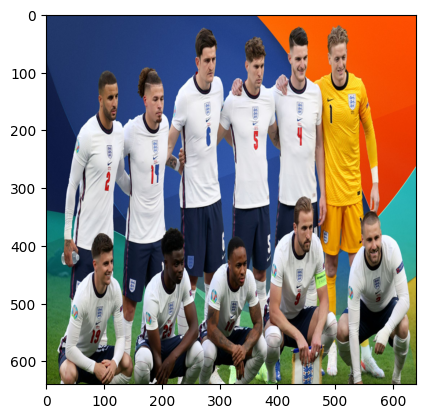

In [6]:
plt.imshow(image_resized)
plt.show()

In [7]:
with torch.no_grad():
    outputs = model(input_tensor)

In [8]:
outputs = outputs[0].cpu().numpy().transpose(1, 0)
rows = outputs.shape[0]

In [9]:
boxes = []
scores = []
class_ids = []

In [12]:
for i in range(rows):
    classes_scores = outputs[i, 4:]
    (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
    if maxScore >= 0.25:
        box = [
            outputs[i, 0] - (0.5 * outputs[i, 2]),
            outputs[i, 1] - (0.5 * outputs[i, 3]),
            outputs[i, 2],
            outputs[i, 3],
        ]
        boxes.append(box)
        scores.append(maxScore)
        class_ids.append(maxClassIndex)

# Apply NMS (Non-maximum suppression)
indices = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45)

0.9033597707748413

In [22]:
for i in indices:
    print(f"Box {i}: [x=",boxes[i][0],", y=",boxes[i][1],", w=",boxes[i][2],", h=",boxes[i][3],"], score=",scores[i],", class_id=",class_ids[i])

Box 108: [x= 20.366241455078125 , y= 380.4849853515625 , w= 135.17578 , h= 259.15503 ], score= 0.9033597707748413 , class_id= 0
Box 90: [x= 500.7054748535156 , y= 340.439208984375 , w= 130.16937 , h= 298.964 ], score= 0.8821361064910889 , class_id= 0
Box 87: [x= 379.6628723144531 , y= 316.81402587890625 , w= 111.44159 , h= 319.4331 ], score= 0.8417941331863403 , class_id= 0
Box 112: [x= 156.4388427734375 , y= 371.63336181640625 , w= 113.19446 , h= 267.90784 ], score= 0.8241612315177917 , class_id= 0
Box 44: [x= 207.76402282714844 , y= 42.74652099609375 , w= 106.16153 , h= 507.13153 ], score= 0.8029254078865051 , class_id= 0
Box 17: [x= 296.6728057861328 , y= 38.99176025390625 , w= 106.37131 , h= 434.90027 ], score= 0.780126690864563 , class_id= 0
Box 20: [x= 384.63623046875 , y= 21.682891845703125 , w= 94.867615 , h= 382.72543 ], score= 0.7792320847511292 , class_id= 0
Box 40: [x= 121.16658782958984 , y= 92.5760498046875 , w= 97.27486 , h= 441.31262 ], score= 0.7734212279319763 , class

Box 108: [(65, 685, 498, 1151)]
Box 90: [(1602, 613, 2019, 1151)]
Box 87: [(1215, 570, 1572, 1145)]
Box 112: [(501, 669, 863, 1151)]
Box 44: [(665, 77, 1005, 990)]
Box 17: [(949, 70, 1290, 853)]
Box 20: [(1231, 39, 1534, 728)]
Box 40: [(388, 167, 699, 961)]
Box 71: [(865, 693, 1220, 1150)]
Box 53: [(89, 174, 442, 901)]
Box 34: [(1479, 34, 1842, 1000)]
Box 5: [(1209, 969, 1312, 1043)]


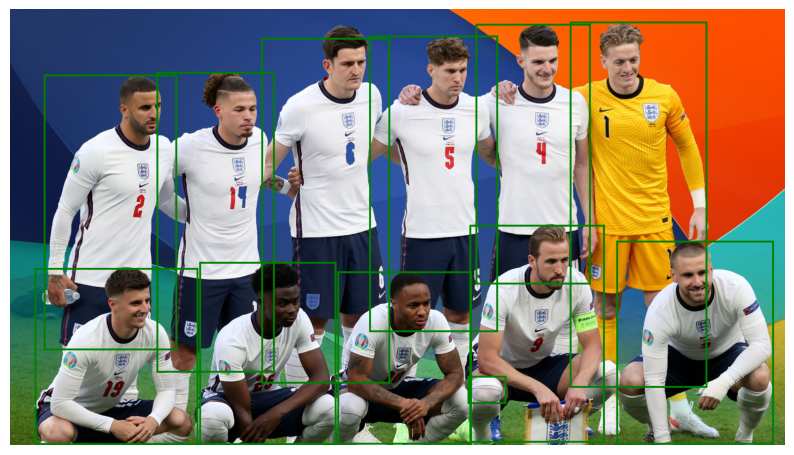

In [25]:
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)
scale_x, scale_y = original_size[0] / 640, original_size[1] / 640
for i in indices:
    box = boxes[i]
    x0, y0, x1, y1 = box[0] * scale_x, box[1] * scale_y, (box[0] + box[2]) * scale_x, (box[1] + box[3]) * scale_y
    if x1 > x0 and y1 > y0:  # Ensure coordinates are correct
        draw.rectangle([x0, y0, x1, y1], outline="green", width=5)
        print(f"Box {i}: [{round(x0),round(y0),round(x1),round(y1)}]")
    else:
        print(f"Skipped invalid box: {box}")

# Convert image to numpy array for plotting
image_np = np.array(image)

# Plot the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
plt.show()